<a href="https://colab.research.google.com/github/suwannee-mauy/DADS6003/blob/main/Part1_classification_VGG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Step 0: ติดตั้งเบื้องต้น

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# 1. Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 2. ตรวจสอบ GPU
!nvidia-smi -L

GPU 0: NVIDIA L4 (UUID: GPU-98d1c52c-1900-ff46-96d6-d5f47a57f4e5)


In [ ]:
!pip install torchinfo

In [ ]:
import os, shutil
import pandas as pd
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from PIL import Image
from torchvision import transforms

# Step 1: เตรียม Dataset

In [ ]:
# Load Metadata
print("📥 Loading metadata...")
metadata_path = "/content/drive/MyDrive/Colab Notebooks/NIDA/DADS7202_Deep/Final_Deep_project/Traffy/metadata.csv"
image_dir = "/content/drive/MyDrive/Colab Notebooks/NIDA/DADS7202_Deep/Final_Deep_project/Traffy/Traffy_cracked_image/crack_834"
output_root = "/content/drive/MyDrive/Colab Notebooks/NIDA/DADS7202_Deep/Final_Deep_project/Traffy/Traffy_cracked_image/crack_834/final_dataset"


df = pd.read_csv(metadata_path)

# ตรวจสอบชื่อคอลัมน์ที่มี space หรือ format ผิด
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')
df["image_path"] = df["ticket_id"].apply(lambda x: os.path.join(image_dir, f"{x}.jpg"))
df = df[df["image_path"].apply(os.path.exists)]
print(f"✅ Metadata loaded. Images found: {len(df)}")
# แสดงตัวอย่าง
df.head()

📥 Loading metadata...


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Colab Notebooks/NIDA/DADS7202_Deep/Final_Deep_project/Traffy/metadata.csv'

In [ ]:
# ดูชื่อไฟล์ 5 ไฟล์แรก
print("📂 ไฟล์ในโฟลเดอร์:")
print(os.listdir(image_dir)[:5])

📂 ไฟล์ในโฟลเดอร์:
['2025-2YUKTK.jpg', '2025-2YFMV8.jpg', '2025-2YD7T6.jpg', '2025-2UNE6Z.jpg', '2025-2UJK7A.jpg']


In [ ]:
#เช็คและแมปไฟล์รูปภาพจาก ticket_id
df["ticket_id"] = df["ticket_id"].str.strip()
image_dir = "/content/drive/MyDrive/Colab Notebooks/NIDA/DADS7202_Deep/Final_Deep_project/Traffy/Traffy_cracked_image/crack_834"

# ใช้ .jpg แทน
df["image_path"] = df["ticket_id"].apply(lambda x: os.path.join(image_dir, f"{x}.jpg"))
df["image_exists"] = df["image_path"].apply(os.path.exists)

# แสดงผลลัพธ์
print("✅ รูปภาพที่พบทั้งหมด:", df["image_exists"].sum(), "/", len(df))


✅ รูปภาพที่พบทั้งหมด: 797 / 797


# Step 2: ตรวจสอบและจัดการ Class Imbalance

In [ ]:
# Oversample to balance classes
print("\n⚖️ Performing oversampling...")
max_count = df["severity_level"].value_counts().max()
df_oversampled = pd.concat([
    resample(df[df["severity_level"] == cls], replace=True, n_samples=max_count, random_state=42)
    for cls in df["severity_level"].unique()])
print(df_oversampled["severity_level"].value_counts())
print("✅ Oversampling completed.")


⚖️ Performing oversampling...
severity_level
Low       413
Medium    413
High      413
Name: count, dtype: int64
✅ Oversampling completed.


In [ ]:
# Augment
from PIL import Image
from torchvision import transforms
import os
import uuid
import pandas as pd

#  สร้าง output temp dir
aug_temp = "/content/drive/MyDrive/Colab Notebooks/NIDA/DADS7202_Deep/Final_Deep_project/Traffy/Traffy_cracked_image/crack_834/augmented_temp"
os.makedirs(aug_temp, exist_ok=True)

#  Define augmentation
print("\n🎨 Augmenting images...")
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=1.0),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
    transforms.RandomRotation(degrees=15)
])

#  Ensure image_full_path exists in df_oversampled
if "image_full_path" not in df_oversampled.columns:
    df_oversampled["image_path"] = df_oversampled["ticket_id"].astype(str) + ".jpg"
    image_dir = "/content/drive/MyDrive/Colab Notebooks/NIDA/DADS7202_Deep/Final_Deep_project/Traffy/Traffy_cracked_image/crack_834"
    df_oversampled["image_full_path"] = df_oversampled["image_path"].apply(lambda x: os.path.join(image_dir, x))

#  Augment loop
aug_records = []
for i, (_, row) in enumerate(df_oversampled.iterrows()):
    image = Image.open(row["image_full_path"]).convert("RGB")
    severity = row["severity_level"]
    ticket_id = row["ticket_id"]

    # ➕ Save original
    orig_path = os.path.join(aug_temp, f"{ticket_id}.jpg")
    image.save(orig_path)
    aug_records.append((orig_path, severity))

    # ➕ Save augmented
    aug_image = transform(image)
    aug_path = os.path.join(aug_temp, f"{ticket_id}_aug_{uuid.uuid4().hex[:6]}.jpg")
    aug_image.save(aug_path)
    aug_records.append((aug_path, severity))

    if (i + 1) % 100 == 0:
        print(f"🖼️ Processed {i+1} / {len(df_oversampled)} images")

#  สร้าง dataframe
df_aug = pd.DataFrame(aug_records, columns=["image_path", "severity_level"])
print("✅ Augmentation completed.")
print(f"📁 Total images (original + aug): {len(aug_records)}")



🎨 Augmenting images...
🖼️ Processed 100 / 1239 images
🖼️ Processed 200 / 1239 images
🖼️ Processed 300 / 1239 images
🖼️ Processed 400 / 1239 images
🖼️ Processed 500 / 1239 images
🖼️ Processed 600 / 1239 images
🖼️ Processed 700 / 1239 images
🖼️ Processed 800 / 1239 images
🖼️ Processed 900 / 1239 images
🖼️ Processed 1000 / 1239 images
🖼️ Processed 1100 / 1239 images
🖼️ Processed 1200 / 1239 images
✅ Augmentation completed.
📁 Total images (original + aug): 2478


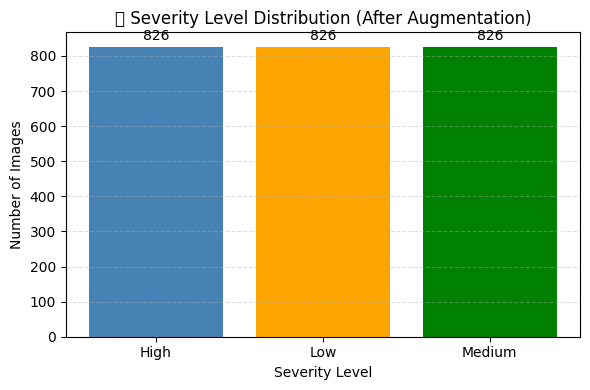

In [ ]:
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

#  นับจำนวน class
severity_counts = df_aug["severity_level"].value_counts().sort_index()

#  วาดกราฟ
plt.figure(figsize=(6, 4))
bars = plt.bar(severity_counts.index, severity_counts.values, color=["steelblue", "orange", "green"])

#  ใส่ label ด้านบนแท่ง
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height + 10, f'{int(height)}', ha='center', va='bottom', fontsize=10)

#  ตกแต่ง
plt.title(" Severity Level Distribution (After Augmentation)")
plt.xlabel("Severity Level")
plt.ylabel("Number of Images")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()



In [ ]:
# Split train/val/test
from sklearn.model_selection import train_test_split
import shutil
import os

#  Split (Stratified 70/15/15)
train_val_df, test_df = train_test_split(
    df_aug,
    test_size=0.15,
    stratify=df_aug["severity_level"],
    random_state=42
)
train_df, val_df = train_test_split(
    train_val_df,
    test_size=0.1765,  # 15% of (train+val)
    stratify=train_val_df["severity_level"],
    random_state=42
)

print(f"✅ Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")

# เตรียมโฟลเดอร์ปลายทาง
output_root = "/content/drive/MyDrive/Colab Notebooks/NIDA/DADS7202_Deep/Final_Deep_project/Traffy/Traffy_cracked_image/crack_834/final_dataset"
for split_name in ["train", "val", "test"]:
    for cls in df_aug["severity_level"].unique():
        os.makedirs(os.path.join(output_root, split_name, cls), exist_ok=True)

#  Function: copy รูป
def copy_images(df_subset, split_name):
    for _, row in df_subset.iterrows():
        src = row["image_path"]
        cls = row["severity_level"]
        dst = os.path.join(output_root, split_name, cls, os.path.basename(src))
        shutil.copy2(src, dst)

#  Run copy
copy_images(train_df, "train")
copy_images(val_df, "val")
copy_images(test_df, "test")

print("✅ Images copied into train/val/test folders.")



✅ Train: 1734 | Val: 372 | Test: 372
✅ Images copied into train/val/test folders.


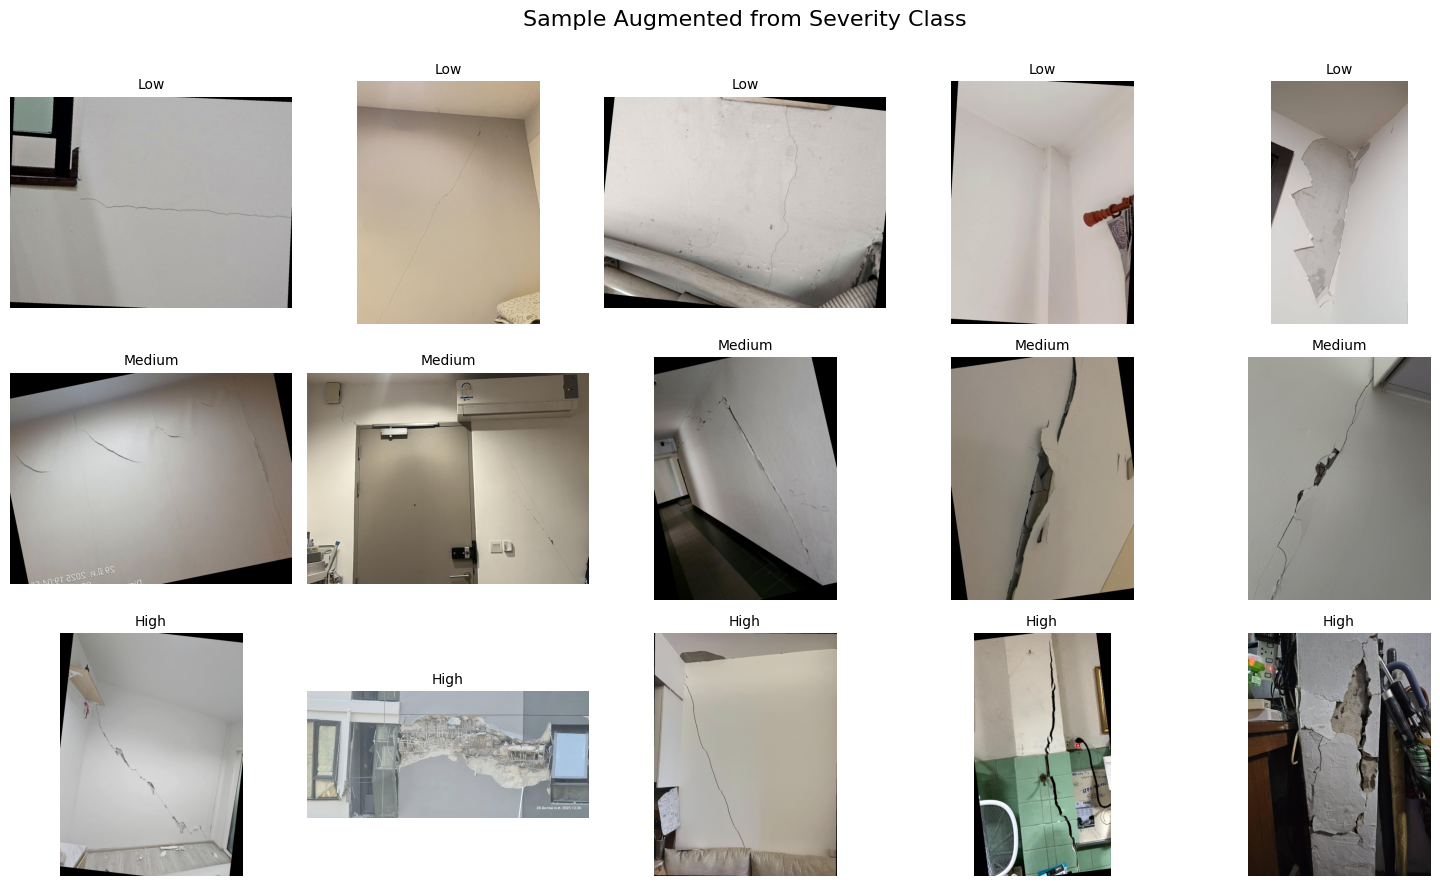

In [ ]:
#แสดงภาพตัวอย่างจากแต่ละ class (สุ่ม 5 รูปต่อ class)
import matplotlib.pyplot as plt
from PIL import Image
import random

#  สุ่ม 5 ภาพต่อ class จาก df_aug
sampled_df = df_aug.groupby("severity_level").apply(lambda x: x.sample(5, random_state=123)).reset_index(drop=True)

#  เตรียม subplot
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 9))
class_order = ["Low", "Medium", "High"]

for i, cls in enumerate(class_order):
    class_samples = sampled_df[sampled_df["severity_level"] == cls]
    for j, (_, row) in enumerate(class_samples.iterrows()):
        ax = axes[i, j]
        try:
            image = Image.open(row["image_path"]).convert("RGB")
            ax.imshow(image)
            ax.set_title(cls, fontsize=10)
        except Exception as e:
            ax.text(0.5, 0.5, "Error", ha='center', va='center', fontsize=8)
        ax.axis("off")

plt.suptitle("Sample Augmented from Severity Class", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.90)
plt.show()



# Step 3: แยก task: Classification

In [ ]:
# Load Dataset ด้วย ImageFolder
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Image Transform
transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # ตัดบางส่วนของภาพแบบสุ่ม
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=20),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Dataset path
#data_dir = "/content/drive/MyDrive/Colab Notebooks/NIDA/DADS7202_Deep/Final_Deep_project/Traffy/Traffy_cracked_image/crack_834/final_dataset"
data_dir = "/content/drive/MyDrive/Colab Notebooks/DADS7202_Deep_Learning/final_project/final_dataset/"


#  ImageFolder
train_dataset = datasets.ImageFolder(root=os.path.join(data_dir, "train"), transform=transform)
val_dataset   = datasets.ImageFolder(root=os.path.join(data_dir, "val"), transform=transform)
test_dataset  = datasets.ImageFolder(root=os.path.join(data_dir, "test"), transform=transform)

#  DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Class mapping
class_names = train_dataset.classes
print("📂 Classes:", class_names)
print("📂 Class mapping:", train_dataset.class_to_idx)


📂 Classes: ['High', 'Low', 'Medium']
📂 Class mapping: {'High': 0, 'Low': 1, 'Medium': 2}


In [ ]:
#ไม่ใช้
#Load Pretrained VGG16 & Modify Classifier
import torch.nn as nn
import torchvision.models as models

# Load model
vgg16 = models.vgg16(pretrained=True)

# Freeze feature layers
for param in vgg16.features.parameters():
    param.requires_grad = False

# Replace final classifier
vgg16.classifier = nn.Sequential(
    nn.Linear(25088, 2048),
    nn.BatchNorm1d(2048),
    nn.ReLU(),
    nn.Dropout(0.5),

    nn.Linear(2048, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Dropout(0.4),

    nn.Linear(512, 128),
    nn.ReLU(),
    nn.Dropout(0.3),                # เดิมเป็น 0.2 → เพิ่มอีกนิด

    nn.Linear(128, 64),            # เพิ่มชั้นกลางเบา ๆ ได้ (optional)
    nn.ReLU(),
    nn.Dropout(0.2),               # Dropout เล็กน้อยก่อน output

    nn.Linear(64, 3)
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = vgg16.to(device)


In [ ]:
#test ไม่ใช้
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim

# Load model
vgg16 = models.vgg16(pretrained=True)

# Freeze ALL feature layers (สำคัญมาก!)
##for param in vgg16.features.parameters():
##    param.requires_grad = False

for param in vgg16.features[-8:].parameters():
    param.requires_grad = True

# ===== ลด Classifier ให้เล็กมาก =====
vgg16.classifier = nn.Sequential(
    nn.Linear(25088, 512),
    nn.ReLU(),
    nn.BatchNorm1d(512),      # เพิ่ม batch normalization
    nn.Dropout(0.6),

    nn.Linear(512, 128),
    nn.ReLU(),
    nn.BatchNorm1d(128),
    nn.Dropout(0.4),

    nn.Linear(128, 3)
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = vgg16.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
#test_final ใช้อันนี้ค่ะ
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim

# Load model
vgg16 = models.vgg16(pretrained=True)

# Freeze ALL feature layers (สำคัญมาก!)
for param in vgg16.features.parameters():
    param.requires_grad = False

#for param in vgg16.features[-8:].parameters():
 #   param.requires_grad = True

# ===== ลด Classifier ให้เล็กมาก =====
vgg16.classifier = nn.Sequential(
    nn.Linear(25088, 512),
    nn.ReLU(),
  #  nn.BatchNorm1d(512),      # เพิ่ม batch normalization
    nn.Dropout(0.7),

    nn.Linear(512, 64),
    nn.ReLU(),
  #  nn.BatchNorm1d(128),
    nn.Dropout(0.5),

    nn.Linear(64, 3)
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = vgg16.to(device)


In [ ]:
# pretrain VGG

!pip install torchsummary
!pip install torchinfo

import torch # Import torch here
import torchvision.models as models
from torchsummary import summary

# โหลด pretrained VGG-16
model = models.vgg16(pretrained=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# แสดง summary
summary(model, input_size=(3, 224, 224))

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [ ]:
# summary model VGG16
from torchsummary import summary

# ถ้า input image คือ (3, 224, 224)
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [ ]:
# Training setup
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from datetime import datetime

#  สร้าง run_id สำหรับ save model แบบ unique
run_id = datetime.now().strftime("%Y%m%d_%H%M%S")
#model_path = f"/content/drive/MyDrive/Colab Notebooks/NIDA/DADS7202_Deep/Final_Deep_project/VGG/best_vgg16_model_{run_id}.pth"
model_path = f"/content/drive/MyDrive/Colab Notebooks/DADS7202_Deep_Learning/final_project/VGG/vgg16_model_{run_id}.pth"

#  Loss & Optimizer

#* ลองแก้ไข
# criterion = nn.CrossEntropyLoss()
class_weights = torch.FloatTensor([1.3, 1.0, 1.4]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)


optimizer = optim.Adam(model.classifier.parameters(), lr=1e-5, weight_decay=1.2e-3)  #เดิม lr=1e-5
#optimizer = torch.optim.Adam([
#    {'params': vgg16.features.parameters(), 'lr': 1e-5, 'weight_decay': 1e-4},  # ต่ำสำหรับ pretrained
#    {'params': vgg16.classifier.parameters(), 'lr': 1e-4, 'weight_decay': 5e-4}  # สูงกว่าสำหรับ classifier
#])

# เพิ่ม Scheduler ตรงนี้
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=3, min_lr=1e-7, verbose=True
)

#  ใช้บันทึกค่าระหว่างเทรน
train_loss_list = []
val_loss_list = []
train_acc_list = []
val_acc_list = []

best_val_acc = 0.0

def train_model(model, train_loader, val_loader, epochs=15):
    global best_val_acc
    for epoch in range(epochs):
        model.train()
        running_loss = 0
        correct = 0
        total = 0

        for images, labels in tqdm(train_loader, desc=f"🔁 Epoch {epoch+1}/{epochs} [Training]"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)

        # 🔍 Validation
        model.eval()
        val_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"🔍 Epoch {epoch+1}/{epochs} [Validation]"):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(val_loader)
        val_acc = 100 * correct / total
        val_loss_list.append(val_loss)
        val_acc_list.append(val_acc)

        print(f"\n📘 Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

        # 💾 Save Best Model
        if val_acc > best_val_acc:
            torch.save(model.state_dict(), model_path)
            best_val_acc = val_acc
            print(f"💾 Best model saved as {model_path} with Val Acc: {val_acc:.2f}%")

    print("🎉 Training completed.")


In [ ]:
# Traning
train_model(model, train_loader, val_loader, epochs=35)


🔍 Epoch 1/35 [Validation]: 100%|██████████| 3/3 [01:10<00:00, 23.41s/it]



📘 Epoch 1/35 | Train Loss: 1.1100 | Train Acc: 35.24% | Val Loss: 1.0780 | Val Acc: 33.89%
💾 Best model saved as /content/drive/MyDrive/Colab Notebooks/DADS7202_Deep_Learning/final_project/VGG/vgg16_model_20250611_140505.pth with Val Acc: 33.89%


🔍 Epoch 2/35 [Validation]: 100%|██████████| 3/3 [00:04<00:00,  1.34s/it]



📘 Epoch 2/35 | Train Loss: 1.0888 | Train Acc: 38.33% | Val Loss: 1.0618 | Val Acc: 38.89%
💾 Best model saved as /content/drive/MyDrive/Colab Notebooks/DADS7202_Deep_Learning/final_project/VGG/vgg16_model_20250611_140505.pth with Val Acc: 38.89%


🔍 Epoch 3/35 [Validation]: 100%|██████████| 3/3 [00:04<00:00,  1.34s/it]



📘 Epoch 3/35 | Train Loss: 1.0632 | Train Acc: 40.48% | Val Loss: 1.0465 | Val Acc: 43.89%
💾 Best model saved as /content/drive/MyDrive/Colab Notebooks/DADS7202_Deep_Learning/final_project/VGG/vgg16_model_20250611_140505.pth with Val Acc: 43.89%


🔍 Epoch 4/35 [Validation]: 100%|██████████| 3/3 [00:03<00:00,  1.32s/it]



📘 Epoch 4/35 | Train Loss: 1.0509 | Train Acc: 44.40% | Val Loss: 1.0273 | Val Acc: 46.67%
💾 Best model saved as /content/drive/MyDrive/Colab Notebooks/DADS7202_Deep_Learning/final_project/VGG/vgg16_model_20250611_140505.pth with Val Acc: 46.67%


🔍 Epoch 5/35 [Validation]: 100%|██████████| 3/3 [00:04<00:00,  1.35s/it]



📘 Epoch 5/35 | Train Loss: 1.0116 | Train Acc: 51.43% | Val Loss: 0.9891 | Val Acc: 53.33%
💾 Best model saved as /content/drive/MyDrive/Colab Notebooks/DADS7202_Deep_Learning/final_project/VGG/vgg16_model_20250611_140505.pth with Val Acc: 53.33%


🔍 Epoch 6/35 [Validation]: 100%|██████████| 3/3 [00:04<00:00,  1.35s/it]



📘 Epoch 6/35 | Train Loss: 1.0113 | Train Acc: 48.69% | Val Loss: 0.9598 | Val Acc: 63.89%
💾 Best model saved as /content/drive/MyDrive/Colab Notebooks/DADS7202_Deep_Learning/final_project/VGG/vgg16_model_20250611_140505.pth with Val Acc: 63.89%


🔍 Epoch 7/35 [Validation]: 100%|██████████| 3/3 [00:04<00:00,  1.34s/it]



📘 Epoch 7/35 | Train Loss: 0.9814 | Train Acc: 56.19% | Val Loss: 0.9346 | Val Acc: 58.89%


🔍 Epoch 8/35 [Validation]: 100%|██████████| 3/3 [00:03<00:00,  1.33s/it]



📘 Epoch 8/35 | Train Loss: 0.9749 | Train Acc: 52.26% | Val Loss: 0.9078 | Val Acc: 62.22%


🔍 Epoch 9/35 [Validation]: 100%|██████████| 3/3 [00:04<00:00,  1.35s/it]



📘 Epoch 9/35 | Train Loss: 0.9621 | Train Acc: 53.69% | Val Loss: 0.8997 | Val Acc: 66.67%
💾 Best model saved as /content/drive/MyDrive/Colab Notebooks/DADS7202_Deep_Learning/final_project/VGG/vgg16_model_20250611_140505.pth with Val Acc: 66.67%


🔍 Epoch 10/35 [Validation]: 100%|██████████| 3/3 [00:04<00:00,  1.35s/it]



📘 Epoch 10/35 | Train Loss: 0.9290 | Train Acc: 55.95% | Val Loss: 0.8841 | Val Acc: 67.22%
💾 Best model saved as /content/drive/MyDrive/Colab Notebooks/DADS7202_Deep_Learning/final_project/VGG/vgg16_model_20250611_140505.pth with Val Acc: 67.22%


🔍 Epoch 11/35 [Validation]: 100%|██████████| 3/3 [00:03<00:00,  1.33s/it]



📘 Epoch 11/35 | Train Loss: 0.9025 | Train Acc: 58.81% | Val Loss: 0.8483 | Val Acc: 70.00%
💾 Best model saved as /content/drive/MyDrive/Colab Notebooks/DADS7202_Deep_Learning/final_project/VGG/vgg16_model_20250611_140505.pth with Val Acc: 70.00%


🔍 Epoch 12/35 [Validation]: 100%|██████████| 3/3 [00:03<00:00,  1.33s/it]



📘 Epoch 12/35 | Train Loss: 0.9086 | Train Acc: 60.24% | Val Loss: 0.8524 | Val Acc: 68.33%


🔍 Epoch 13/35 [Validation]: 100%|██████████| 3/3 [00:03<00:00,  1.33s/it]



📘 Epoch 13/35 | Train Loss: 0.8848 | Train Acc: 60.24% | Val Loss: 0.8204 | Val Acc: 70.00%


🔍 Epoch 14/35 [Validation]: 100%|██████████| 3/3 [00:03<00:00,  1.33s/it]



📘 Epoch 14/35 | Train Loss: 0.9008 | Train Acc: 58.33% | Val Loss: 0.8110 | Val Acc: 71.11%
💾 Best model saved as /content/drive/MyDrive/Colab Notebooks/DADS7202_Deep_Learning/final_project/VGG/vgg16_model_20250611_140505.pth with Val Acc: 71.11%


🔍 Epoch 15/35 [Validation]: 100%|██████████| 3/3 [00:03<00:00,  1.33s/it]



📘 Epoch 15/35 | Train Loss: 0.8587 | Train Acc: 63.81% | Val Loss: 0.8050 | Val Acc: 71.11%


🔍 Epoch 16/35 [Validation]: 100%|██████████| 3/3 [00:03<00:00,  1.32s/it]



📘 Epoch 16/35 | Train Loss: 0.8802 | Train Acc: 62.14% | Val Loss: 0.8062 | Val Acc: 68.89%


🔍 Epoch 17/35 [Validation]: 100%|██████████| 3/3 [00:04<00:00,  1.34s/it]



📘 Epoch 17/35 | Train Loss: 0.8115 | Train Acc: 65.24% | Val Loss: 0.8039 | Val Acc: 67.78%


🔍 Epoch 18/35 [Validation]: 100%|██████████| 3/3 [00:04<00:00,  1.39s/it]



📘 Epoch 18/35 | Train Loss: 0.8220 | Train Acc: 63.69% | Val Loss: 0.7572 | Val Acc: 69.44%


🔍 Epoch 19/35 [Validation]: 100%|██████████| 3/3 [00:04<00:00,  1.37s/it]



📘 Epoch 19/35 | Train Loss: 0.8330 | Train Acc: 65.48% | Val Loss: 0.7816 | Val Acc: 71.67%
💾 Best model saved as /content/drive/MyDrive/Colab Notebooks/DADS7202_Deep_Learning/final_project/VGG/vgg16_model_20250611_140505.pth with Val Acc: 71.67%


🔍 Epoch 20/35 [Validation]: 100%|██████████| 3/3 [00:04<00:00,  1.36s/it]



📘 Epoch 20/35 | Train Loss: 0.8036 | Train Acc: 65.83% | Val Loss: 0.7561 | Val Acc: 72.22%
💾 Best model saved as /content/drive/MyDrive/Colab Notebooks/DADS7202_Deep_Learning/final_project/VGG/vgg16_model_20250611_140505.pth with Val Acc: 72.22%


🔍 Epoch 21/35 [Validation]: 100%|██████████| 3/3 [00:04<00:00,  1.35s/it]



📘 Epoch 21/35 | Train Loss: 0.8160 | Train Acc: 64.17% | Val Loss: 0.7493 | Val Acc: 72.22%


🔍 Epoch 22/35 [Validation]: 100%|██████████| 3/3 [00:04<00:00,  1.38s/it]



📘 Epoch 22/35 | Train Loss: 0.7841 | Train Acc: 67.98% | Val Loss: 0.7434 | Val Acc: 67.22%


🔍 Epoch 23/35 [Validation]: 100%|██████████| 3/3 [00:04<00:00,  1.35s/it]



📘 Epoch 23/35 | Train Loss: 0.7894 | Train Acc: 67.86% | Val Loss: 0.7600 | Val Acc: 70.00%


🔍 Epoch 24/35 [Validation]: 100%|██████████| 3/3 [00:04<00:00,  1.36s/it]



📘 Epoch 24/35 | Train Loss: 0.7989 | Train Acc: 67.26% | Val Loss: 0.7454 | Val Acc: 70.56%


🔍 Epoch 25/35 [Validation]: 100%|██████████| 3/3 [00:04<00:00,  1.35s/it]



📘 Epoch 25/35 | Train Loss: 0.7672 | Train Acc: 68.10% | Val Loss: 0.7325 | Val Acc: 71.67%


🔍 Epoch 26/35 [Validation]: 100%|██████████| 3/3 [00:04<00:00,  1.35s/it]



📘 Epoch 26/35 | Train Loss: 0.7533 | Train Acc: 70.48% | Val Loss: 0.7323 | Val Acc: 68.33%


🔍 Epoch 27/35 [Validation]: 100%|██████████| 3/3 [00:04<00:00,  1.35s/it]



📘 Epoch 27/35 | Train Loss: 0.7329 | Train Acc: 71.43% | Val Loss: 0.6980 | Val Acc: 71.11%


🔍 Epoch 28/35 [Validation]: 100%|██████████| 3/3 [00:04<00:00,  1.35s/it]



📘 Epoch 28/35 | Train Loss: 0.7694 | Train Acc: 69.64% | Val Loss: 0.7064 | Val Acc: 75.00%
💾 Best model saved as /content/drive/MyDrive/Colab Notebooks/DADS7202_Deep_Learning/final_project/VGG/vgg16_model_20250611_140505.pth with Val Acc: 75.00%


🔍 Epoch 29/35 [Validation]: 100%|██████████| 3/3 [00:04<00:00,  1.34s/it]



📘 Epoch 29/35 | Train Loss: 0.7427 | Train Acc: 70.71% | Val Loss: 0.7139 | Val Acc: 71.67%


🔍 Epoch 30/35 [Validation]: 100%|██████████| 3/3 [00:04<00:00,  1.33s/it]



📘 Epoch 30/35 | Train Loss: 0.7140 | Train Acc: 71.19% | Val Loss: 0.7016 | Val Acc: 73.33%


🔍 Epoch 31/35 [Validation]: 100%|██████████| 3/3 [00:03<00:00,  1.33s/it]



📘 Epoch 31/35 | Train Loss: 0.7293 | Train Acc: 70.95% | Val Loss: 0.6936 | Val Acc: 72.22%


🔍 Epoch 32/35 [Validation]: 100%|██████████| 3/3 [00:03<00:00,  1.33s/it]



📘 Epoch 32/35 | Train Loss: 0.7196 | Train Acc: 71.31% | Val Loss: 0.7118 | Val Acc: 67.22%


🔍 Epoch 33/35 [Validation]: 100%|██████████| 3/3 [00:04<00:00,  1.35s/it]



📘 Epoch 33/35 | Train Loss: 0.7147 | Train Acc: 70.24% | Val Loss: 0.6943 | Val Acc: 72.22%


🔍 Epoch 34/35 [Validation]: 100%|██████████| 3/3 [00:04<00:00,  1.37s/it]



📘 Epoch 34/35 | Train Loss: 0.7323 | Train Acc: 70.48% | Val Loss: 0.7149 | Val Acc: 71.11%


🔍 Epoch 35/35 [Validation]: 100%|██████████| 3/3 [00:04<00:00,  1.34s/it]


📘 Epoch 35/35 | Train Loss: 0.7053 | Train Acc: 70.12% | Val Loss: 0.6786 | Val Acc: 72.22%
🎉 Training completed.


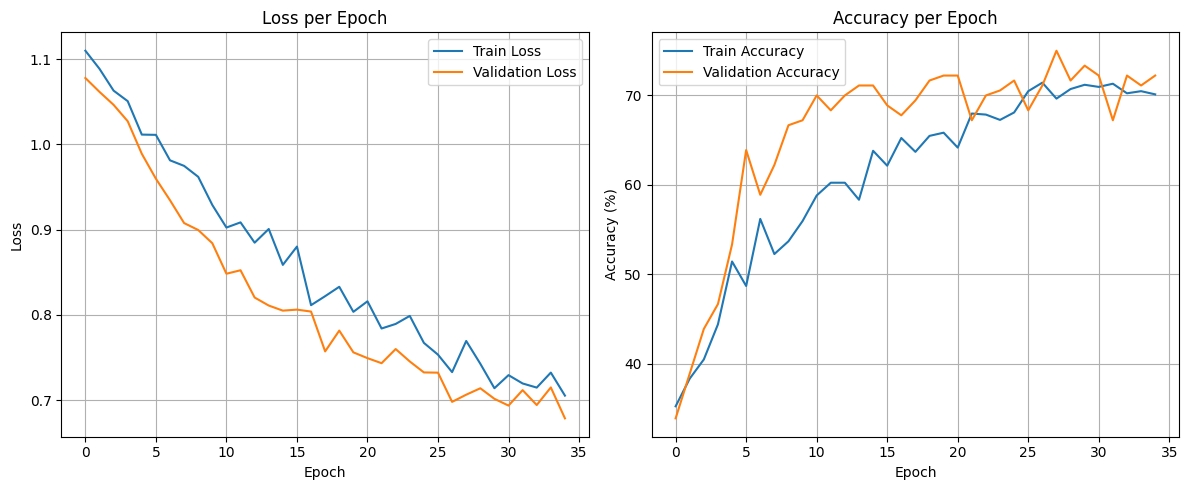

In [ ]:
import matplotlib.pyplot as plt
# 📈 Plot training history
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc_list, label='Train Accuracy')
plt.plot(val_acc_list, label='Validation Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Load best model

#model.load_state_dict(torch.load( "/content/drive/MyDrive/Colab Notebooks/DADS7202_Deep_Learning/final_project/VGG/best_vgg16_model_20250606_100822.pth", map_location=device))

#model.load_state_dict(torch.load( "/content/drive/MyDrive/Colab Notebooks/DADS7202_Deep_Learning/final_project/VGG/vgg16_model_20250610_131416.pth", map_location=device))

# ส่งโมเดลไปที่ device ที่กำลังใช้
model = model.to(device)
model.eval()


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# Evaluation
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import random

# โหลด model ที่ดีที่สุด
model.load_state_dict(torch.load(model_path))
model.eval()

# class mapping
idx_to_class = {v: k for k, v in test_dataset.class_to_idx.items()}


<ipython-input-150-c8abd5b179e7>:26: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


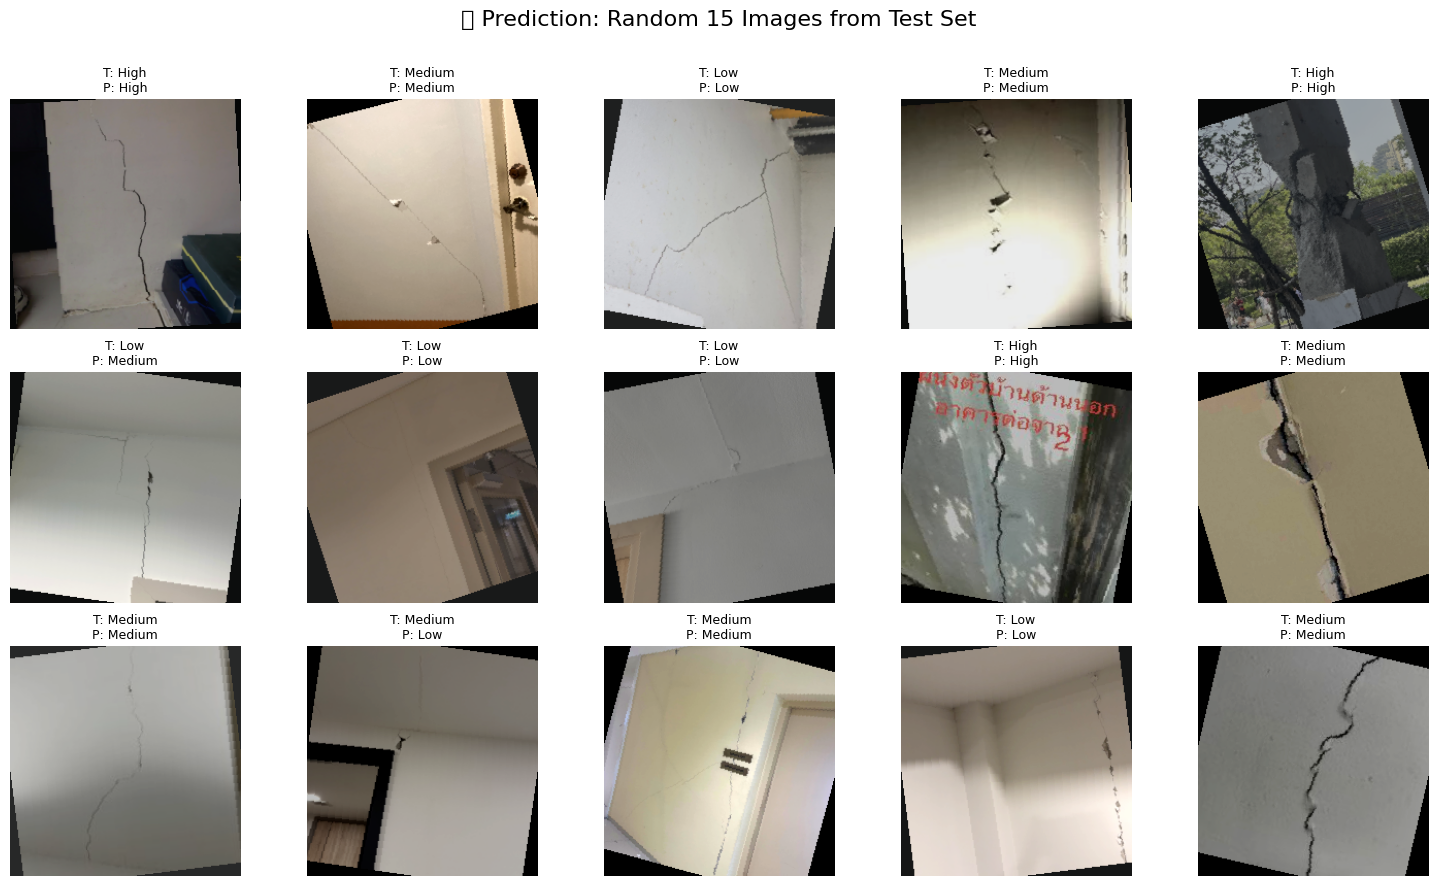

In [ ]:
# สุ่ม 15 รูปจาก test_dataset
sample_indices = random.sample(range(len(test_dataset)), 15)
fig, axes = plt.subplots(3, 5, figsize=(15, 9))

for i, idx in enumerate(sample_indices):
    image, label = test_dataset[idx]
    image_input = image.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image_input)
        pred = torch.argmax(output, dim=1).item()

    true_label = idx_to_class[label]
    pred_label = idx_to_class[pred]

    ax = axes[i // 5, i % 5]
    img_np = image.permute(1, 2, 0).cpu().numpy()
    img_np = img_np * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # unnormalize
    img_np = np.clip(img_np, 0, 1)

    ax.imshow(img_np)
    ax.axis("off")
    ax.set_title(f"T: {true_label}\nP: {pred_label}", fontsize=9)

plt.suptitle("🔍 Prediction: Random 15 Images from Test Set", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()



In [ ]:
#  Evalute & Predict ทั้ง test set
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(labels.numpy())

#  Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(idx_to_class.values()))
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("📊 Confusion Matrix (Test Set)")
plt.show()

#  Classification Report
print(" Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=list(idx_to_class.values())))


NameError: name 'confusion_matrix' is not defined